**4. Evaluation Metrics for Classification**
>In the previous session a model for predicting churn. How do we know if it;s good?



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

**Importing the data**

> as you can see hear i import the data from google drive but in your case you can get only from you local file



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [ ]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [ ]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

**4.2 Accuracy and dummy model**

*   Evaluate the model on different thresholds
*   Check the accuracy of dummy baselines



In [ ]:
len(y_val)

1409

In [ ]:
(y_val == churn_decision).mean()

0.8034066713981547

In [ ]:
thresholds = np.linspace(0 , 1 , 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

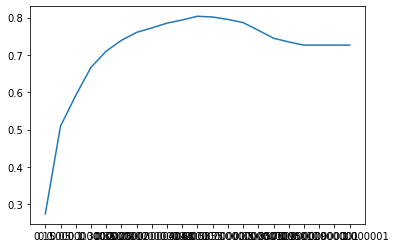

In [ ]:
list = {}
for i in thresholds:
  churn_decision = (y_pred >= i)
  result = (churn_decision == y_val).mean()
  list[i] = result

items = sorted(list.items())
keys_str = [str(key) for key, value in items]
values = [value for key, value in items]

plt.plot(keys_str, values)
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_val , y_pred >= 0.5)

0.8034066713981547

**4.3 Confusion Table**

*   Different types of error and correct decisions
*   Arranging them in a table



In [ ]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [ ]:
predicted_positive = (y_pred >=0.5)
predicted_negative = (y_pred <= 0.5)

In [ ]:
TP = (predicted_positive & actual_positive).sum()
FP = (predicted_positive & actual_negative).sum()
TP.sum()

210

In [ ]:
TN = (predicted_negative & actual_negative).sum()
FN = (predicted_negative & actual_positive).sum()
TN.sum()

922

In [ ]:
confusion_matrix = np.array([[TN , FP],[FN , TP]])
confusion_matrix / confusion_matrix.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

**4.4 Precision and Recall**

In [ ]:
precision =  TP / (TP + FP)
recall = TP / (TP + FN)

**4.5 ROC CURVES**
> TPR and FPR




In [ ]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TPR , FPR

(0.5440414507772021, 0.09872922776148582)

**Random model**

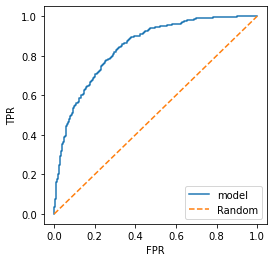

In [ ]:
from sklearn.metrics import roc_curve
fpr  , tpr , thresholds = roc_curve(y_val , y_pred)
plt.figure(figsize=(4 , 4))
plt.plot( fpr  ,tpr, label = 'model')
plt.plot([0,1] , [0 , 1] , label = 'Random' , linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()


In [ ]:
((y_pred >= 0.5) == y_val).mean()

0.8034066713981547

In [ ]:
from sklearn.metrics import auc

In [ ]:
auc(fpr , tpr)

0.8438530381535563

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val , y_pred)

0.8438530381535563

**4.6 Cross Validation**

*   Evaluating the same model on different subset of data
*   Getting the average prediction and the spread within prediction



In [ ]:
def train(df , y , d):
  dicts = df[categorical + numerical].to_dict(orient = 'records')
  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)
  model = LogisticRegression(C = d)
  model.fit(X_train , y)
  return dv , model

In [ ]:
dv , model = train(df_train , y_train ,0.001)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def predict(df_train , dv , model):
  dicts = df_train[categorical +numerical].to_dict(orient = 'records')
  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:,1]
  return y_pred

In [ ]:
y_pred = predict(df_val , dv , model)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5 , shuffle = True , random_state = 1)

In [ ]:

for train_idx , val_idx in kfold.split(df_full_train):
      df_train = df_full_train.iloc[train_idx]
      df_val = df_full_train.iloc[val_idx]
      y_train = df_train.churn.values
      y_val = df_val.churn.values
      dv , model = train(df_train , y_train , d = 0.01)
      y_pred = predict(df_val , dv , model)
      auc = roc_auc_score(y_val , y_pred)
      score.append(auc)
    

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
dv , model = train(df_full_train , df_full_train.churn.values , d = 1.0)
y_pred = predict(df_test , dv , model)
auc = roc_auc_score(y_test , y_pred)
auc

0.8572386167896259

**Save the model**

In [ ]:
import pickle

In [ ]:
output_file = f'model_C.bin'
output_file

'model_C=10.bin'

In [ ]:
f_out = open(output_file, 'wb')
pickle.dump((dv , model), f_out)
f_out.close()

In [ ]:
with open(output_file, 'wb') as f_out:
  pickle.dump((dv, model) , f_out)

**load the model**

In [ ]:
import pickle

In [ ]:
model_file = 'model_C.bin'

In [ ]:
with open(model_file , 'rb') as f_in :
  dv , model = pickle.load(f_in)

In [ ]:
dv , model

(DictVectorizer(sparse=False), LogisticRegression())